# Get histone mod. ChIP-seq datasets from Roadmap Epigenomics

We're limiting our training on histone modification ChIP-seq datasets targeting the following modifications:

- H3K4me1
- H3K4me3
- H3K27ac
- H3K9ac
- H3K27me3
- H3K9me3
- H3K36me3

The list of all datasets is available at https://egg2.wustl.edu/roadmap/data/byFileType/signal/consolidated/macs2signal/foldChange/

In [195]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Imports

In [143]:
import io
import json
import numpy as np
import os
import pandas as pd
import requests
import sys
from urllib.parse import urlencode, urljoin

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../experiments'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [62]:
base = '..'
datasets_file = 'roadmap-epigenomics.tsv'
mods = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K9ac', 'H3K9me3', 'H3K36me3']

In [63]:
roadmap_datasets = pd.read_csv(os.path.join(base, 'data', datasets_file), sep='\t', header=None, names=('id', 'target', 'size'))

In [46]:
from functools import reduce

filters = [roadmap_datasets['filename'].str.lower().str.contains(mod.lower()) for mod in mods]
all_filters = reduce(lambda a, b: a | b, filters)

In [112]:
selected_datasets = roadmap_datasets[all_filters]

In [136]:
"""Select experiments that feature all targets"""
tmp = selected_datasets.groupby(['id']).agg(['count'])
tmp = tmp['target'] == 7
tmp = tmp.index[tmp['count'].values]
datasets_with_all_targets = selected_datasets[selected_datasets['id'].isin(np.array(tmp))]
e_ids = datasets_with_all_targets['id'].unique().tolist()

#### Estimate size

In [61]:
N = len(roadmap_datasets)
subsample = [72, 72, 72, 54, 54, 54, 54]
selected = None

for i, f in enumerate(filters):
    if selected is None:
        selected = np.random.choice(np.arange(N)[f], subsample[i], replace=False)
    else:
        selected = np.concatenate((selected, np.random.choice(np.arange(N)[f], subsample[i], replace=False)))
        
roadmap_datasets.iloc[selected]['size'].sum() / 1000

205.707

#### Save JSON

In [126]:
with open('../datasets-chip-histone-mod-hg19.json'.format(), 'w') as f:
    json.dump(e_ids, f)

## Download data

In [183]:
from download import download_roadmap_epigenomics

with open('../settings-roadmap-epigenomics-chip-histone-mod-12kb-testing.json'.format(), 'r') as f:
    settings = json.load(f)

download_roadmap_epigenomics(
    [e_ids[0]],
    settings,
    base='..'
)

In [191]:
from bedtobigbed import bed_to_bigbed

bed_to_bigbed(
    [e_ids[0]],
    settings,
    base='..',
    clear=True,
)

In [192]:
from prepare import get_roadmap_datasets, prepare

prepare(
    'chip',
    get_roadmap_datasets([e_ids[0]], 'chip'),
    settings,
    roadmap=True,
    clear=True,
    verbose=True,
    silent=False,
)

Window size: 12000bp
Resolution: 100bp
Bins per window: 120
Step frequency per window: 2
Step size: 6000bp
Chromosomes: chr21, chr22
Dev set size: 7.5%
Test set size: 7.5%
Percentile cut off: [0, 99.9]

Prepare dataset E003


Extract windows from E003-H3K4me1.fc.signal.bigWig..
Extract narrow peaks from E003-H3K4me1.peaks.narrow.bigBed..
Extract broad peaks from E003-H3K4me1.peaks.broad.bigBed..
Select windows to balance peaky and non-peaky ratio
Windows: total = 16571 | with peaks = 8597 | with signal gt 50 pctl = 4374
Extract windows from E003-H3K4me3.fc.signal.bigWig..
Extract narrow peaks from E003-H3K4me3.peaks.narrow.bigBed..
Extract broad peaks from E003-H3K4me3.peaks.broad.bigBed..
Select windows to balance peaky and non-peaky ratio
Windows: total = 16571 | with peaks = 6842 | with signal gt 50 pctl = 3813
Train: 9056 (with 64.21% peaks) Dev: 799 (with 66.08% peaks) Test: 800 (with 62.38% peaks)
Saving... done!


Evaluate(verbose=True)...


Start evaluate merged
Evaluate 1826 windows... 
Evaluate batch 0:20480
Batch shape (1826, 120, 1)
Prediction of batch 0:20480 took 0.6308727264404297 sec
Evaluate 0 keras metrics
Evaluate 3 numpy metrics
Computing the numpy metrics of batch 0:20480 took 0.008350849151611328 sec
Evaluation of batch 0:20480 took 0.8627519607543945 sec
Plot windows...


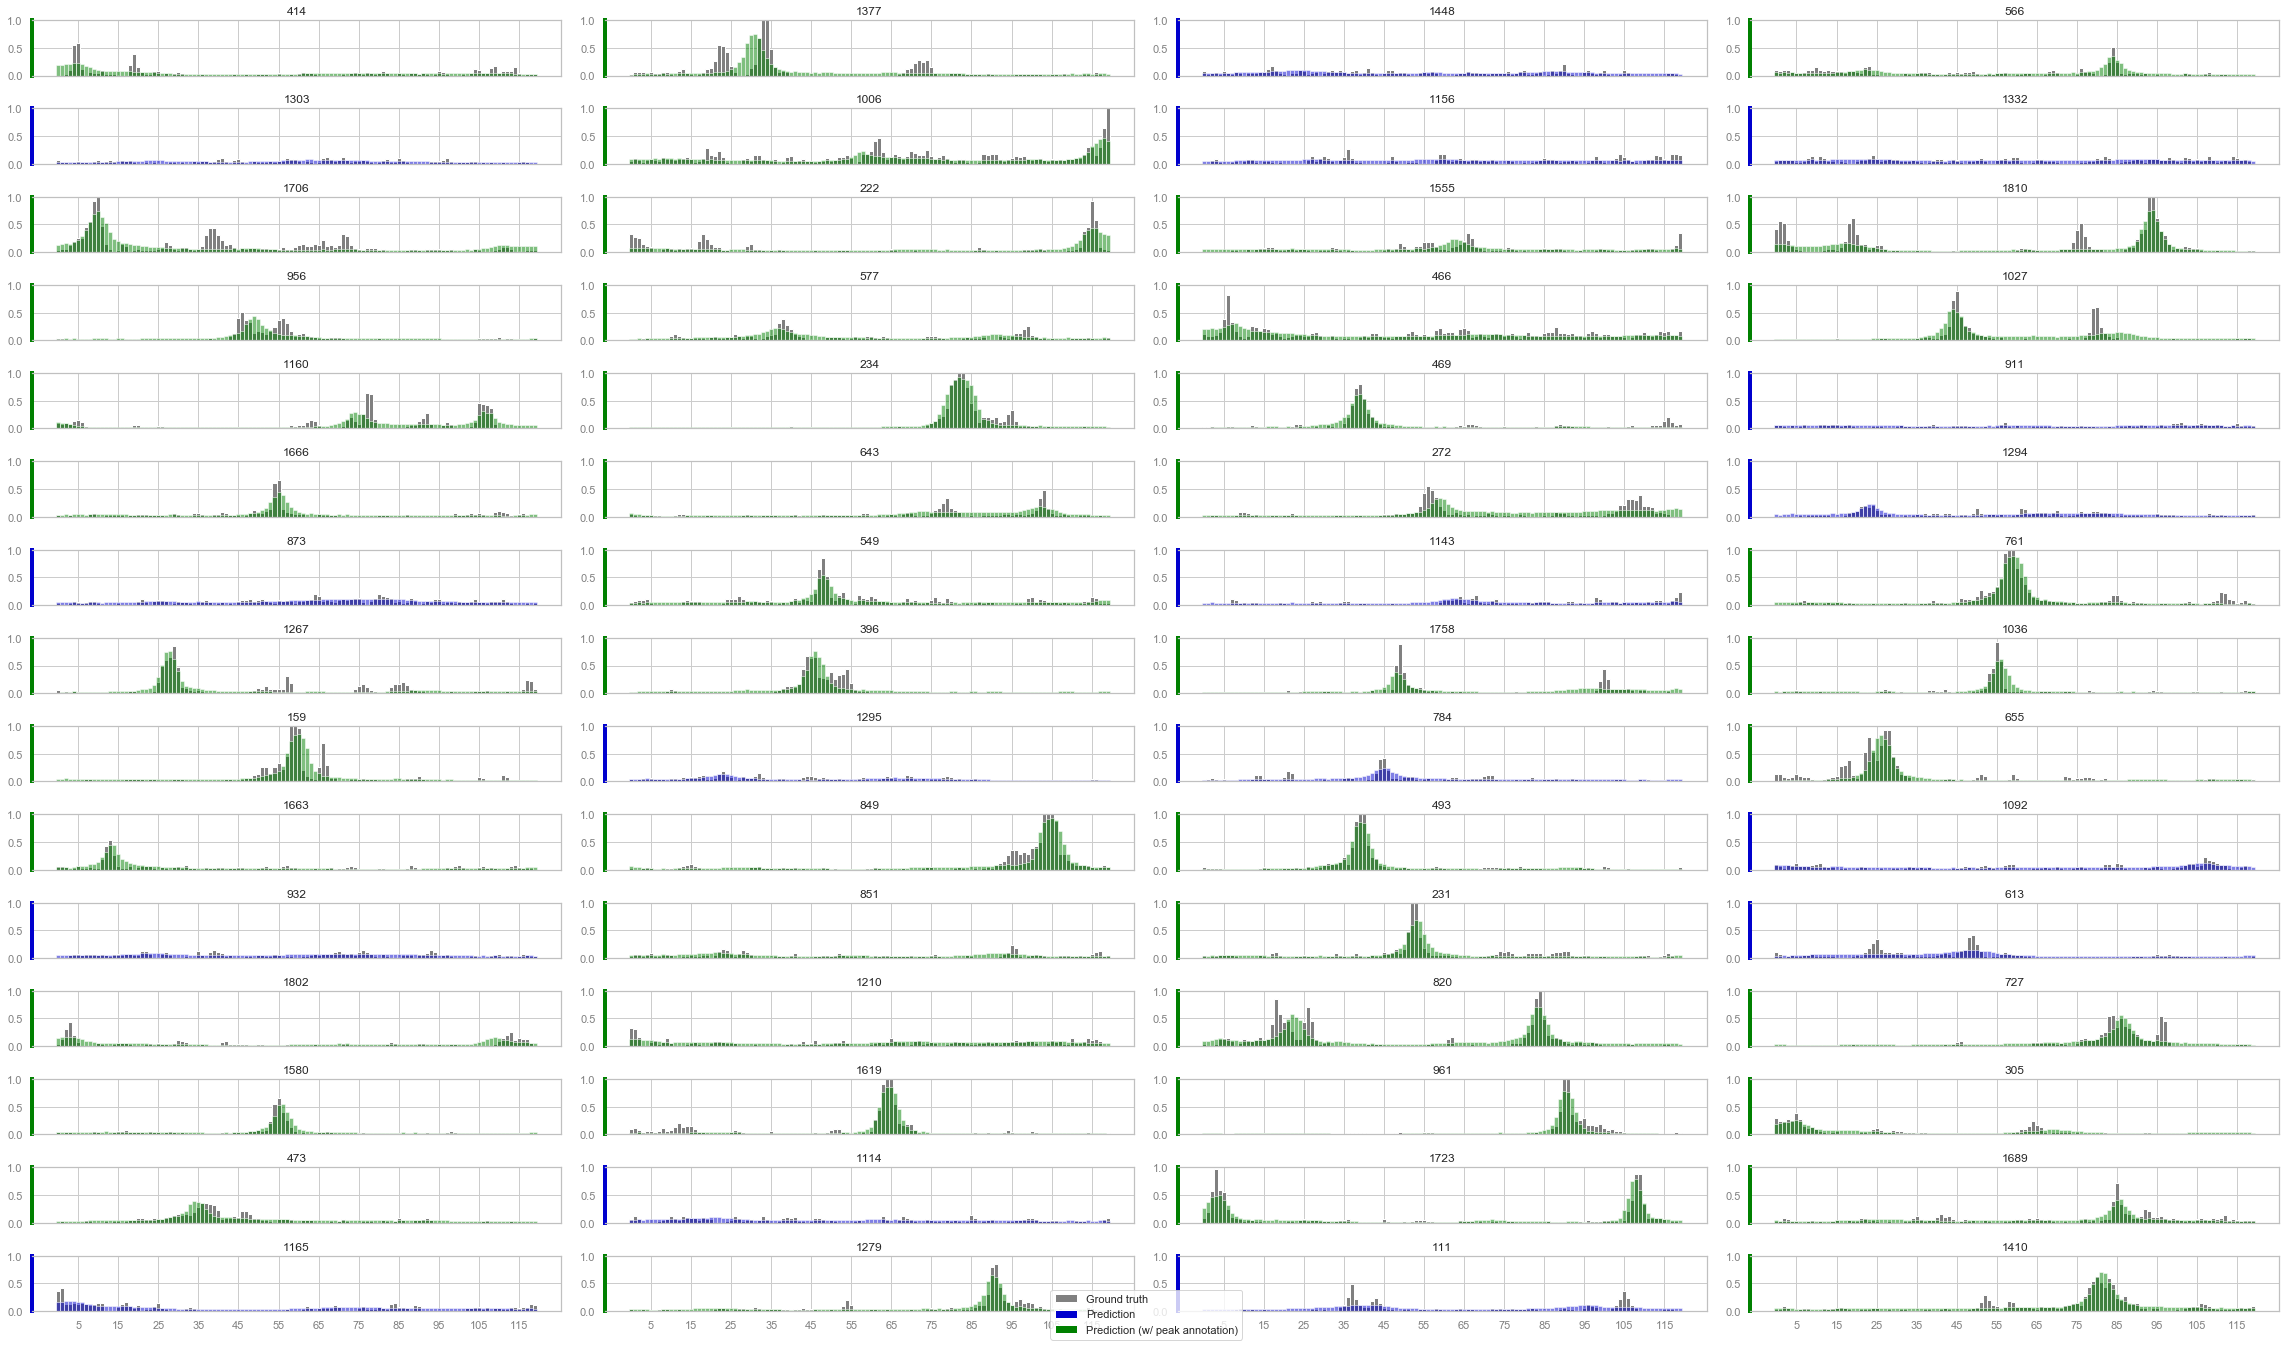

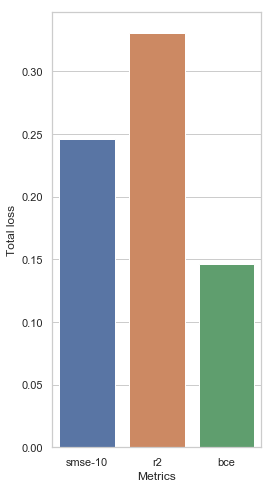

In [202]:
from evaluate import evaluate
loss = evaluate(
    model_name = 'cf-32-64-128--ck-3-5-7--du-1024-256--do-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0',
    dataset_name = 'merged',
    base = '..',
    clear = True,
    verbose = True,
)

In [203]:
loss

array([[0.28373606, 0.33051636, 0.19442124],
       [0.47186613, 0.33051636, 0.26255186],
       [0.24256656, 0.33051636, 0.24940572],
       ...,
       [0.41555293, 0.33051636, 0.2149729 ],
       [0.0998896 , 0.33051636, 0.19552429],
       [0.091987  , 0.33051636, 0.14489525]])